In [ ]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install kmodes
!pip install catboost


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
import shap


In [4]:
df = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv",sep="\t")
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Feature Engineering¶
# 

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# income is the only column with null values.  I delete those rows with null values
df = df.dropna(subset=['Income']).reset_index(drop=True) 

below I

1) combine binary variables in columns 20-24+28 into one column since they all point to the same question: whether the customer responded positively to a campaign by making a purchase

2) creat a new column age and enrollment_time and deleting year_birth and Dt_customer columns

3) create livingwith column that simplifies marital status column by assinging 1 to together and 0 to single status.

4) create children column that combines kidhome and teenhome columns.

5) simplify the education column by giving undergraduate degrees 0, graduate 1 and postgraduate 2




In [7]:
# renaming the response column as 6'th acceptedcmp because it shows whether the customer responded positively to the last campaing
df = df.rename(columns={'Response': 'AcceptedCmp6'})

df['Camp_responses']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['AcceptedCmp6']
campaign_dict = {'AcceptedCmp1': 1, 'AcceptedCmp2': 2, 'AcceptedCmp3': 3,
                 'AcceptedCmp4': 4, 'AcceptedCmp5': 5, 'AcceptedCmp6': 6}

df.drop(columns=campaign_dict.keys(), inplace=True)

# calculate age based on Year_Birth
current_year = dt.datetime.now().year
df['Age'] = current_year - df['Year_Birth']

# convert 'Dt_Customer' to datetime format and calculate enrollment time as number of months
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Enrollment_time'] = ((dt.datetime.now() - df['Dt_Customer']).dt.days / 12).round(1)

# drop the original columns
df.drop(columns=['Year_Birth', 'Dt_Customer'], inplace=True)

df["Living_With"]=df["Marital_Status"].replace({"Married":"1", "Together":"1", "Absurd":"0", "Widow":"0", "YOLO":"0", "Divorced":"0", "Single":"0",})

## To get a more clarity about family's background
df["Children"]=df["Kidhome"]+df["Teenhome"]
df.drop(columns=['Marital_Status', 'Kidhome', 'Teenhome'], inplace=True)


#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"0","2n Cycle":"0", "Graduation":"1", "Master":"2", "PhD":"2"})

# delete the redundant ID column
df.drop(columns=['ID'], inplace=True)



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Income               2216 non-null   float64
 2   Recency              2240 non-null   int64  
 3   MntWines             2240 non-null   int64  
 4   MntFruits            2240 non-null   int64  
 5   MntMeatProducts      2240 non-null   int64  
 6   MntFishProducts      2240 non-null   int64  
 7   MntSweetProducts     2240 non-null   int64  
 8   MntGoldProds         2240 non-null   int64  
 9   NumDealsPurchases    2240 non-null   int64  
 10  NumWebPurchases      2240 non-null   int64  
 11  NumCatalogPurchases  2240 non-null   int64  
 12  NumStorePurchases    2240 non-null   int64  
 13  NumWebVisitsMonth    2240 non-null   int64  
 14  Complain             2240 non-null   int64  
 15  Z_CostContact        2240 non-null   i

some of these columns are indeed categorical such as education(3 values), Camp_reponses(6  values), children(3 values), complain(binary) and living with(binary).That is why, I convert these variables into type 'string'.  But why not use some sort of labeling or encoding and feed them into a clustering algorithm such as Kmeans? 

Traditional clustering algoritms such as dbscan, kmeans and hierarchical clustering are based on numeral distance and are known to be not working for non-continuous [variables](https://ijseas.com/volume2/v2i2/ijseas20160238.pdf). That's why, I would have to use K-mode clustering for categorical values and k-means for continous variables. Luckily, [kprototype](https://www.sciencedirect.com/science/article/abs/pii/S0925231213004773) uses both of those methods for mixed type datasets such as this dataset. 



In [8]:
df['Education'] = df['Education'].astype('string')
df['Living_With'] = df['Living_With'].astype('string')
# df['Children'] = df['Children'].astype('string')
# df['Camp_reponses'] = df['Camp_responses'].astype('string')
df['Complain'] = df['Complain'].astype('string')

# ALL COlumns need to be either integer or string for some of the models I will call below. 
df['Enrollment_time'] = df['Enrollment_time'].astype('int')
df['Income'] = df['Income'].astype('int')


OUTLIER DETECTION

Starting with whiskers plot of each integer variables is a good idea to detect outliers 

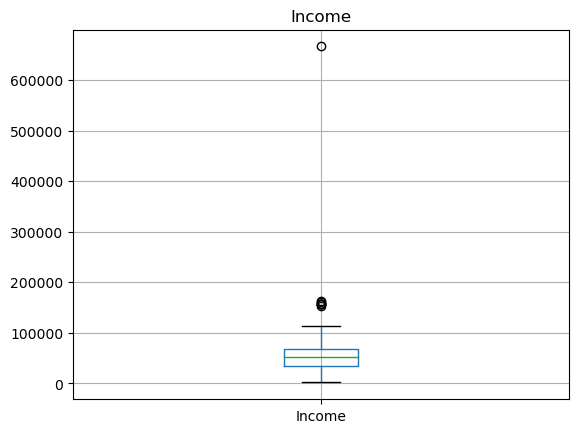

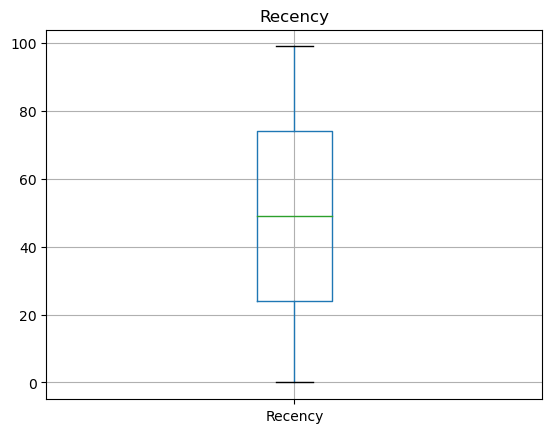

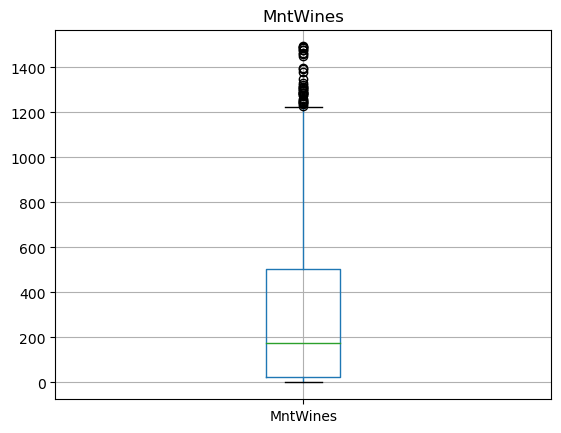

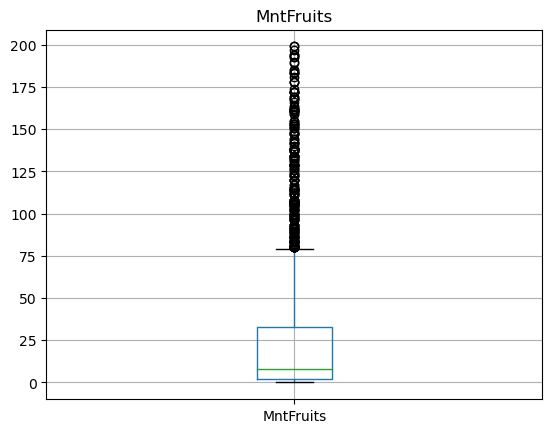

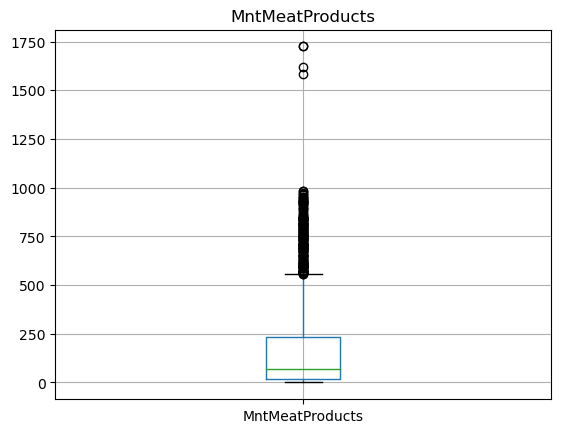

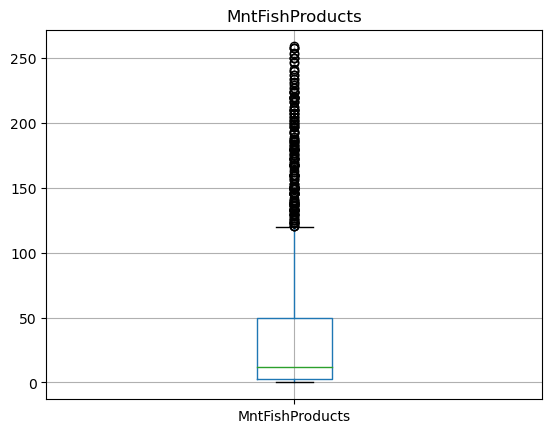

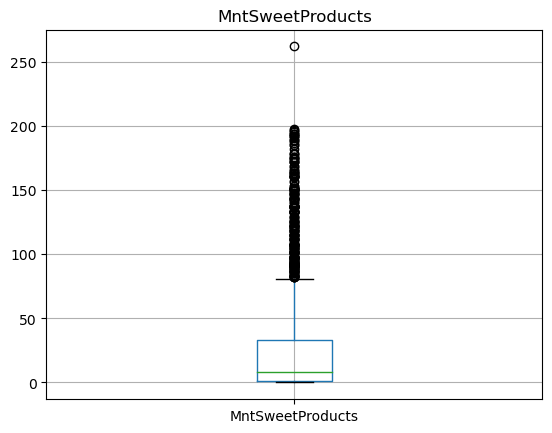

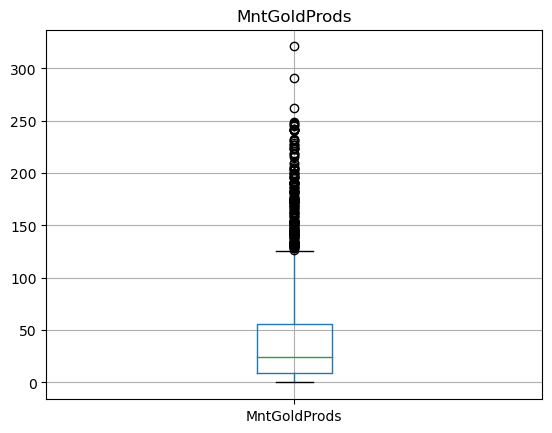

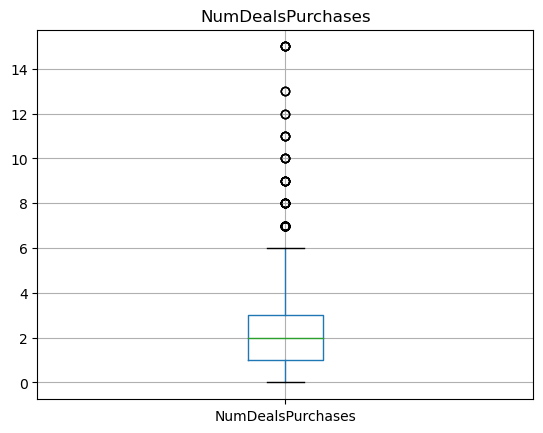

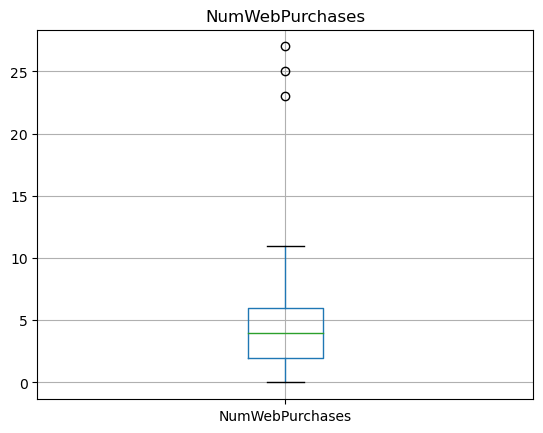

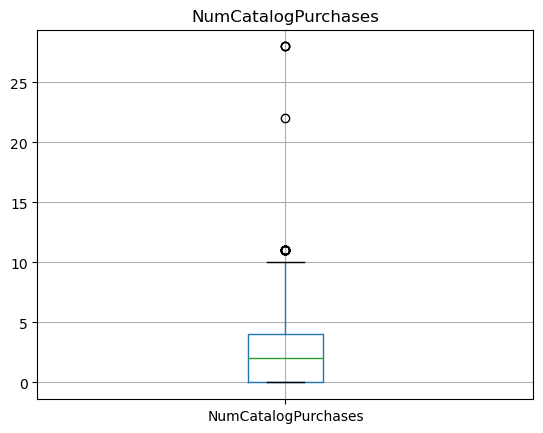

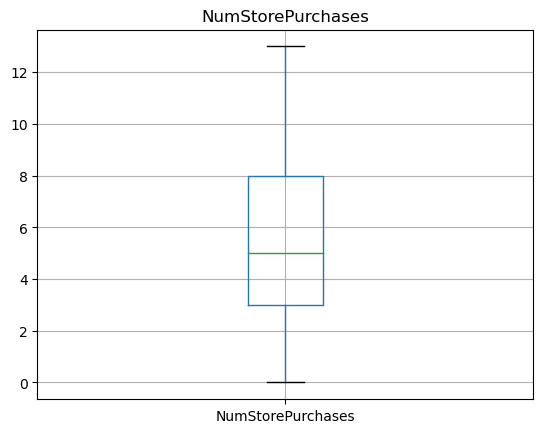

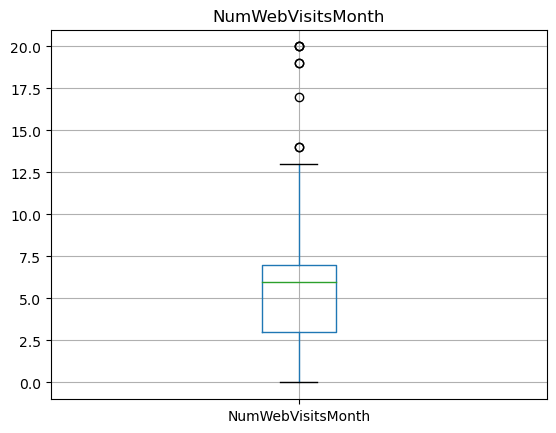

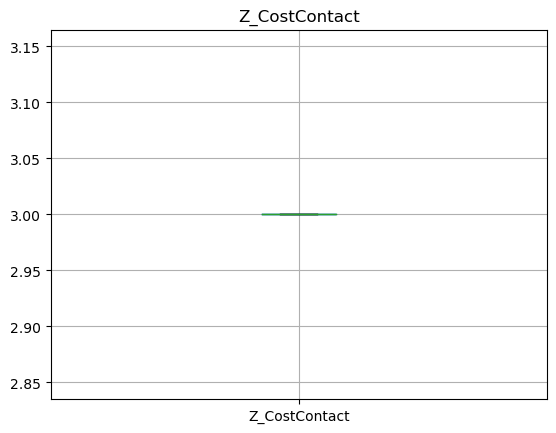

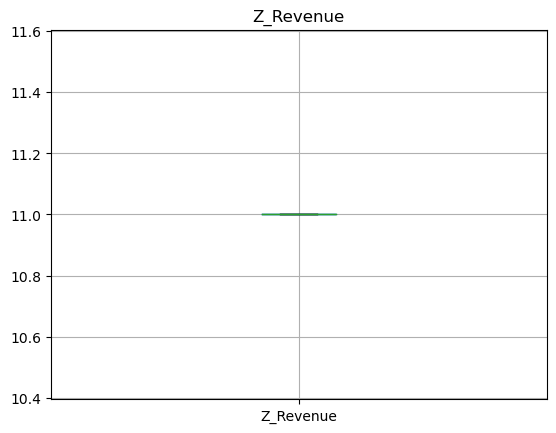

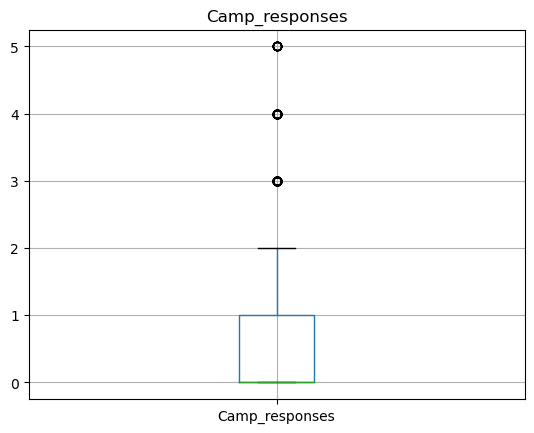

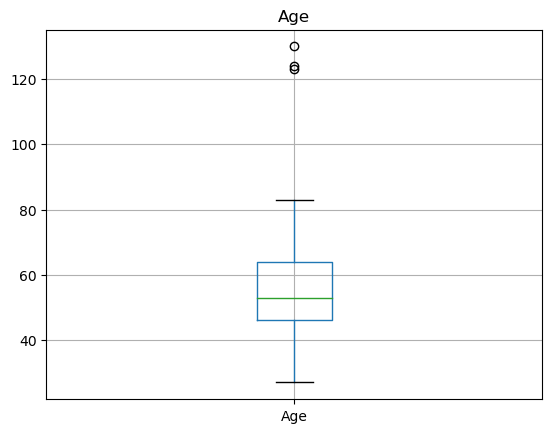

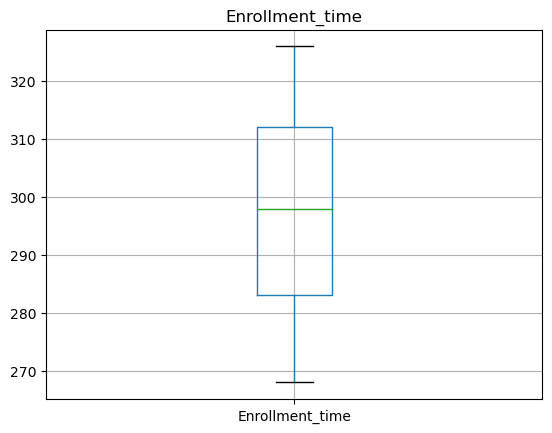

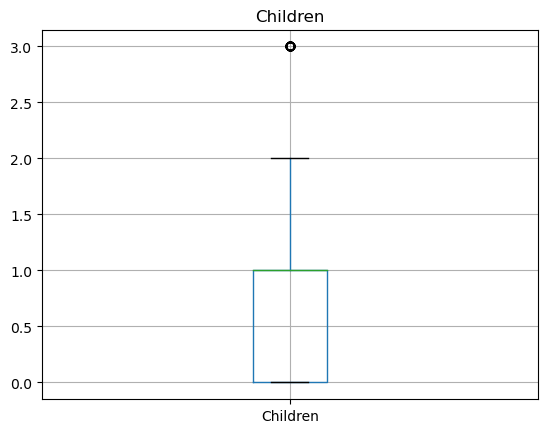

In [9]:
# Filter out string columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Create box plots for each numeric column
for col in numeric_cols:
    df[[col]].boxplot()
    plt.title(col)
    plt.show()


most of the columns have outliers as you can observe on the box plot. I delete outliers using box plot formula.

In [10]:
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    a = q1 - 1.5 * iqr
    b = q3 + 1.5 * iqr
    outliers = df[(df[col] < a) | (df[col] > b)]
    outlier_index = outliers.index
    df.drop(outlier_index, inplace=True)
df = df.reset_index(drop=True)

now we have one third of the rows in the original dataset.

In [11]:
df.describe()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue,Camp_responses,Age,Enrollment_time,Children
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.00000,837.000000,837.0,837.0,837.0,837.000000,837.000000,837.000000
mean,34771.143369,51.028674,41.080048,4.286738,20.982079,6.048984,4.000000,12.357228,1.988053,2.097969,0.440860,3.23417,6.344086,3.0,11.0,0.0,51.997611,294.032258,1.273596
std,12024.378774,28.805056,54.287662,6.225160,22.676230,7.469955,4.951197,12.388652,1.162554,1.345721,0.607295,0.82144,1.601772,0.0,0.0,0.0,11.057483,16.187379,0.697180
min,7500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.00000,1.000000,3.0,11.0,0.0,28.000000,268.000000,0.000000
25%,26091.000000,26.000000,8.000000,0.000000,7.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,3.00000,5.000000,3.0,11.0,0.0,44.000000,279.000000,1.000000
50%,34421.000000,51.000000,20.000000,2.000000,14.000000,3.000000,2.000000,8.000000,2.000000,2.000000,0.000000,3.00000,7.000000,3.0,11.0,0.0,51.000000,293.000000,1.000000
75%,42997.000000,77.000000,50.000000,6.000000,25.000000,8.000000,6.000000,17.000000,3.000000,3.000000,1.000000,4.00000,8.000000,3.0,11.0,0.0,60.000000,307.000000,2.000000
max,69139.000000,99.000000,365.000000,51.000000,206.000000,47.000000,25.000000,66.000000,6.000000,8.000000,2.000000,5.00000,10.000000,3.0,11.0,0.0,83.000000,326.000000,3.000000


In [12]:
# deleting the z_costcontact and Z_revenue columns as they have zero variation and therefore no use for clustering purposes 
df = df.drop(columns=['Z_CostContact', 'Z_Revenue'])


In [13]:
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children
0,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2
1,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,280,1,1
2,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,303,1,1
3,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0
4,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [16]:
# select columns with data type 'string'
object_cols = df.select_dtypes(include=['string']).columns

# get the index of the object columns
object_cols_index = object_cols.to_list()

object_cols_index = [df.columns.get_loc(col) for col in object_cols]


print(object_cols_index)  


[0, 14, 18]


In [17]:
df_scaled=df.copy()
# select only the non-object columns
non_obj_cols = df_scaled.select_dtypes(exclude=['string']).columns

# apply robust standization to the non-object columns 
scaler = RobustScaler()
df_scaled[non_obj_cols] = scaler.fit_transform(df_scaled[non_obj_cols])


df_scaled.describe().round()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Camp_responses,Age,Enrollment_time,Children
count,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0,837.0
mean,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
min,-2.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-1.0,0.0,-1.0,-2.0,0.0,-1.0,-1.0,-1.0
25%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-1.0,0.0,-0.0,-0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
max,2.0,1.0,8.0,8.0,11.0,6.0,4.0,4.0,2.0,3.0,2.0,2.0,1.0,0.0,2.0,1.0,2.0


Applying the elbow method to find the optimal cluster number.

In [18]:
cost = []
for num_clusters in list(range(1,8)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_scaled, categorical=object_cols_index)
    cost.append(kproto.cost_)




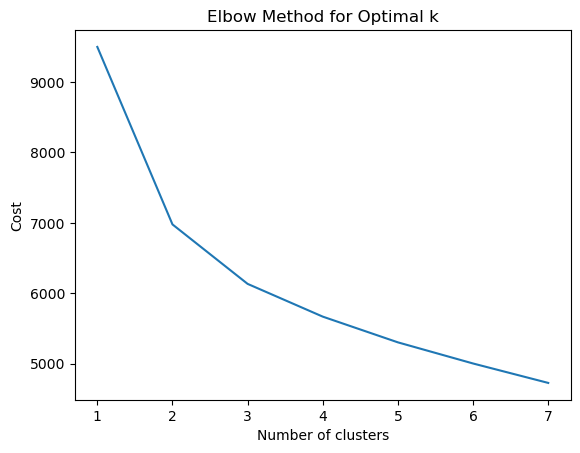

In [19]:
plt.plot(range(1, 8), cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

K=3 seems like a good choice. so lets re-train with k=3 this time with more initializations.

In [20]:
    kproto = KPrototypes(n_clusters=3, init='Cao', n_init=100)
    kproto.fit_predict(df_scaled, categorical=object_cols_index)


array([1, 1, 2, 0, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1,
       1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1,
       1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0,


SHAPLEY VALUE ANALYSIS OF CLUSTERS

I will analyse shapley values to understand which features are most important for each cluster. For this purpose
I add the cluster values to the original DF and will apply Catboost to now labeled dataset to understand feature importance through SHAPLEY values. Such an analysis helps with cluster analysis for datasets with high dimensions. 

In [21]:
df['cluster']=kproto.labels_
df.head()

,Education,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Camp_responses,Age,Enrollment_time,Living_With,Children,cluster
0,1,46344,38,11,1,6,2,1,6,2,1,1,2,5,0,0,69,277,0,2,1
1,1,26646,26,11,4,20,10,3,5,2,2,0,4,6,0,0,39,280,1,1,1
2,2,33454,32,76,10,56,3,1,23,2,4,0,4,8,0,0,38,303,1,1,2
3,0,7500,59,6,16,11,11,1,16,1,2,0,3,8,0,0,47,317,1,0,0
4,2,59354,53,233,2,53,3,5,14,3,6,1,5,6,0,0,71,287,0,2,2


there is no need for train test split and worry about overfitting because we won't use the model for prediction purposes but to explore which features are important for each of the three clusters. So I first train a 
catboost model becuase the datasets contains a mixture of categorical and numerical variables. I will then analyze feature importance for each cluster through SHAP values. 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            837 non-null    string
 1   Income               837 non-null    int64 
 2   Recency              837 non-null    int64 
 3   MntWines             837 non-null    int64 
 4   MntFruits            837 non-null    int64 
 5   MntMeatProducts      837 non-null    int64 
 6   MntFishProducts      837 non-null    int64 
 7   MntSweetProducts     837 non-null    int64 
 8   MntGoldProds         837 non-null    int64 
 9   NumDealsPurchases    837 non-null    int64 
 10  NumWebPurchases      837 non-null    int64 
 11  NumCatalogPurchases  837 non-null    int64 
 12  NumStorePurchases    837 non-null    int64 
 13  NumWebVisitsMonth    837 non-null    int64 
 14  Complain             837 non-null    string
 15  Camp_responses       837 non-null    int64 
 16  Age     

In [23]:
# catboost requires the labels to be type integer
df['cluster'] = df['cluster'].astype('int')


In [24]:
X = df.drop('cluster', axis=1)
y = df['cluster']

catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, loss_function='MultiClass', eval_metric='Accuracy', random_seed=42)

catboost.fit(X, y, cat_features=object_cols_index)




0:	learn: 0.8566308	total: 60.3ms	remaining: 5.97s
1:	learn: 0.9103943	total: 65.3ms	remaining: 3.2s
2:	learn: 0.9354839	total: 69ms	remaining: 2.23s
3:	learn: 0.9438471	total: 72.4ms	remaining: 1.74s
4:	learn: 0.9581840	total: 75.7ms	remaining: 1.44s
5:	learn: 0.9629630	total: 79ms	remaining: 1.24s
6:	learn: 0.9629630	total: 81.7ms	remaining: 1.08s
7:	learn: 0.9689367	total: 84.6ms	remaining: 973ms
8:	learn: 0.9701314	total: 87.8ms	remaining: 887ms
9:	learn: 0.9725209	total: 91ms	remaining: 819ms
10:	learn: 0.9749104	total: 94ms	remaining: 761ms
11:	learn: 0.9749104	total: 97.2ms	remaining: 713ms
12:	learn: 0.9737157	total: 100ms	remaining: 672ms
13:	learn: 0.9761051	total: 103ms	remaining: 635ms
14:	learn: 0.9737157	total: 106ms	remaining: 603ms
15:	learn: 0.9737157	total: 109ms	remaining: 574ms
16:	learn: 0.9749104	total: 113ms	remaining: 551ms
17:	learn: 0.9761051	total: 116ms	remaining: 528ms
18:	learn: 0.9761051	total: 119ms	remaining: 508ms
19:	learn: 0.9796894	total: 122ms	rema

In [25]:
explainer = shap.TreeExplainer(catboost, cat_features=object_cols_index)

# Computing SHAP values for the training data
shap_values = explainer(X).values


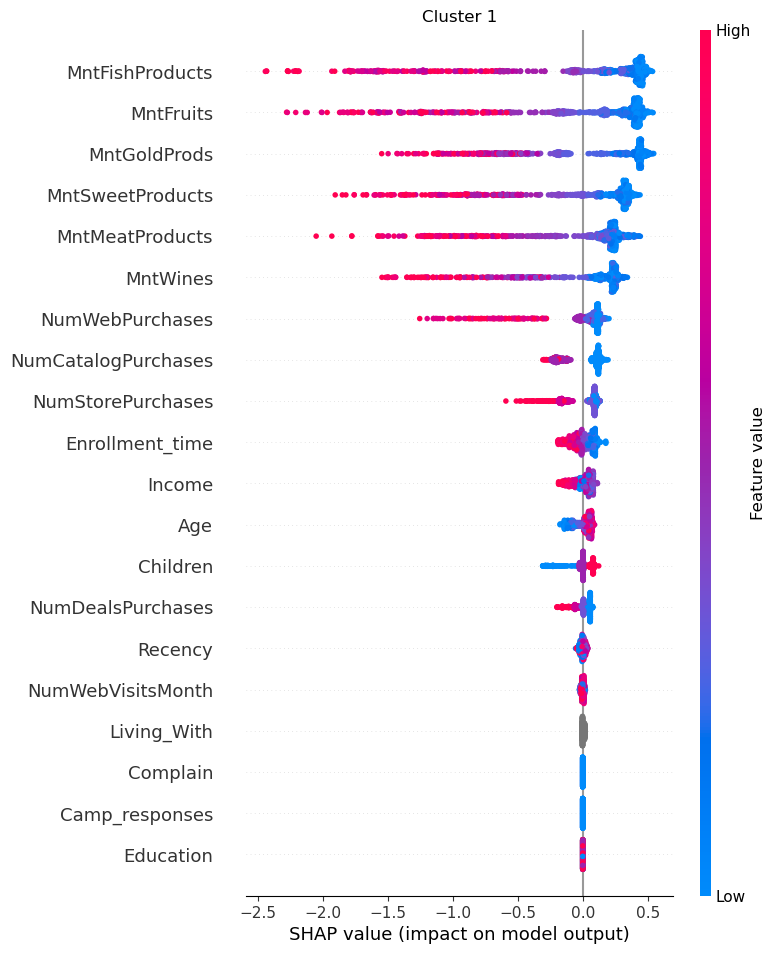

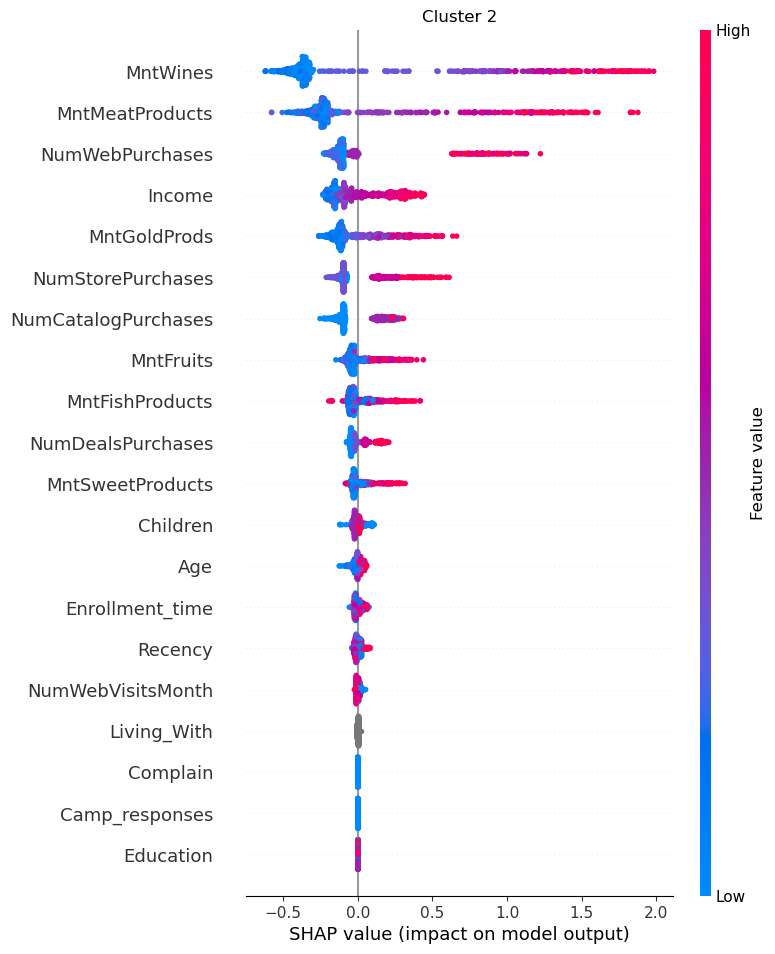

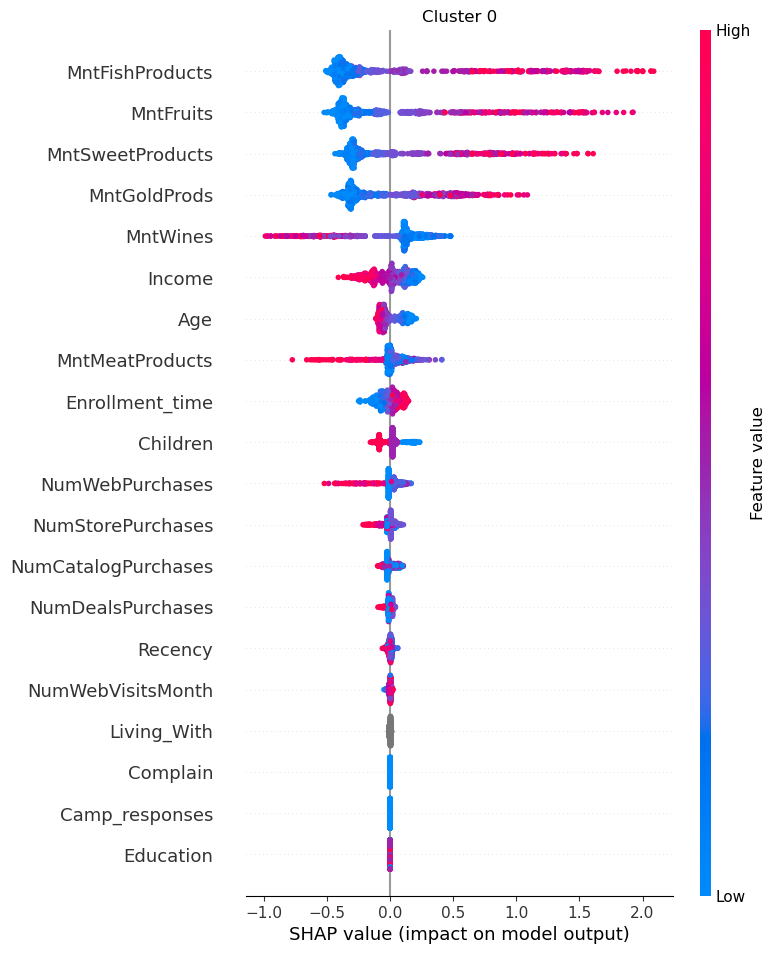

In [26]:
for cnr in df['cluster'].unique():
    shap.summary_plot(shap_values[:, :, cnr], X, max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

In [119]:
df['Living_With'].value_counts

<bound method IndexOpsMixin.value_counts of 0      0
1      1
2      1
3      1
4      0
      ..
832    1
833    1
834    1
835    0
836    1
Name: Living_With, Length: 837, dtype: string>